In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from xgboost import XGBRegressor
from scipy.stats import randint
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
os.chdir("C:\\Users\\omkarp\\Downloads\\Stodata\\")
data = pd.read_excel('Stodf.xlsx')
data = data.dropna()
data = data.reset_index(drop=True)
data

,FID_grid,x,y,count_trip,TEn_ur,THin_ur,TOth_ur,Resi_lur,Comm_lur,Edu_lur,...,LUP_Health,LUP_Other,T_Enable,T_Hinder,T_Other,week_weeke,season_Spr,season_Sum,season_Win,DISTANCE
0,10,671201.8641,6575992.31,7,0,0,0,0.00001,1.00001,0.00001,...,0,0,0,0,0,0,0,0,1,5685.068161
1,10,671201.8641,6575992.31,14,0,0,0,0.00001,1.00001,0.00001,...,0,0,0,0,0,1,0,0,1,5685.068161
2,17,674001.8641,6575992.31,8,0,0,0,0.00001,1.00001,0.00001,...,0,0,0,0,0,0,0,0,1,4472.135955
3,18,674401.8641,6575992.31,5,0,0,0,0.00001,0.00001,0.00001,...,0,62,0,0,0,0,0,0,1,4418.144407
4,18,674401.8641,6575992.31,5,0,0,0,0.00001,0.00001,0.00001,...,0,62,0,0,0,1,0,0,1,4418.144407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,896,672001.8641,6586392.31,12,0,1,0,0.00000,0.00000,0.00000,...,0,0,0,12,0,1,0,1,0,6621.178143
2711,897,672401.8641,6586392.31,7,0,0,0,0.00001,1.00001,0.00001,...,0,0,0,0,0,0,0,0,0,6462.197769
2712,897,672401.8641,6586392.31,9,0,0,0,0.00001,1.00001,0.00001,...,0,0,0,0,0,1,0,0,0,6462.197769
2713,897,672401.8641,6586392.31,22,0,0,0,0.00001,1.00001,0.00001,...,0,0,0,0,0,0,0,1,0,6462.197769


In [12]:
data['Health_lur'].unique()

array([1.00000e-05, 0.00000e+00, 1.00001e+00])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715 entries, 0 to 2714
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   FID_grid    2715 non-null   int64  
 1   x           2715 non-null   float64
 2   y           2715 non-null   float64
 3   count_trip  2715 non-null   int64  
 4   TEn_ur      2715 non-null   int64  
 5   THin_ur     2715 non-null   int64  
 6   TOth_ur     2715 non-null   int64  
 7   Resi_lur    2715 non-null   float64
 8   Comm_lur    2715 non-null   float64
 9   Edu_lur     2715 non-null   float64
 10  Recre_lur   2715 non-null   float64
 11  Public_lur  2715 non-null   float64
 12  Health_lur  2715 non-null   float64
 13  Other_lur   2715 non-null   float64
 14  entropy     2715 non-null   float64
 15  AreaProx    2715 non-null   float64
 16  Pop_den     2715 non-null   float64
 17  PopM_den    2715 non-null   float64
 18  PopF_den    2715 non-null   float64
 19  Empl_den    2715 non-null  

# Feature Selection

74.39189686924493
29.0


<Axes: xlabel='count_trip', ylabel='Count'>

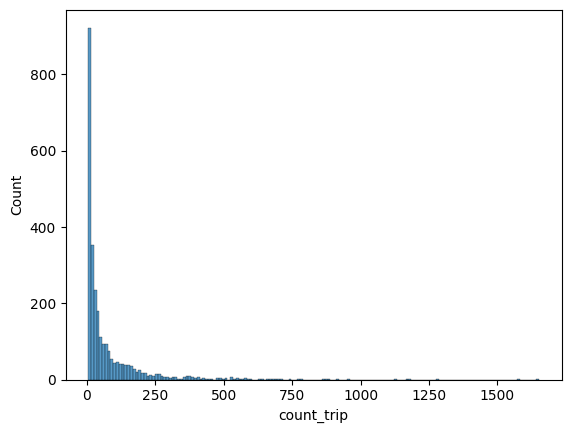

In [4]:
print(data['count_trip'].mean())
print(data['count_trip'].median())
sns.histplot(data['count_trip'])

day_encoder = OneHotEncoder(sparse=False, drop='first')
day_encoded = day_encoder.fit_transform(data[['week']])
day_columns = day_encoder.get_feature_names(['week'])
day_df = pd.DataFrame(day_encoded, columns=day_columns)
data = pd.concat([data, day_df], axis=1)

month_encoder = OneHotEncoder(sparse=False, drop='first')
month_encoded = month_encoder.fit_transform(data[['season']])
month_columns = month_encoder.get_feature_names(['season'])
month_df = pd.DataFrame(month_encoded, columns=month_columns)
data = pd.concat([data, month_df], axis=1)
data = data.drop(['week', 'season'], axis=1)
data.head()

In [5]:
data.columns

Index(['FID_grid', 'x', 'y', 'count_trip', 'TEn_ur', 'THin_ur', 'TOth_ur',
       'Resi_lur', 'Comm_lur', 'Edu_lur', 'Recre_lur', 'Public_lur',
       'Health_lur', 'Other_lur', 'entropy', 'AreaProx', 'Pop_den', 'PopM_den',
       'PopF_den', 'Empl_den', 'MEmpl_den', 'FEmpl_den', 'Inc_den', 'Veh_den',
       'Vused_den', 'Vunus_den', 'Rd_Pri', 'Rd_Sec', 'Rd_Ter', 'Rd_Cyc',
       'Rd_Pedes', 'Rd_Other', 'LUP_Resi', 'LUP_Comm', 'LUP_Edu', 'LUP_Recre',
       'LUP_Public', 'LUP_Health', 'LUP_Other', 'T_Enable', 'T_Hinder',
       'T_Other', 'week_weeke', 'season_Spr', 'season_Sum', 'season_Win',
       'DISTANCE'],
      dtype='object')

## Feature Importance

In [6]:
selected_columns = ['count_trip', 'TEn_ur', 'THin_ur', 'TOth_ur','Resi_lur', 'Comm_lur', 'Edu_lur', 'Recre_lur', 'Public_lur',
                    'Health_lur', 'Other_lur', 'entropy', 'AreaProx','Pop_den','PopM_den','PopF_den','Empl_den','MEmpl_den',
                    'FEmpl_den', 'Inc_den', 'Veh_den','Vused_den', 'Vunus_den', 'Rd_Pri', 'Rd_Sec', 'Rd_Ter', 'Rd_Cyc',
                    'Rd_Pedes', 'Rd_Other', 'LUP_Resi', 'LUP_Comm', 'LUP_Edu', 'LUP_Recre','LUP_Public', 'LUP_Health',
                    'LUP_Other', 'T_Enable', 'T_Hinder','T_Other', 'week_weeke', 'season_Spr', 'season_Sum', 'season_Win',
                    'DISTANCE']

dependent_var = 'count_trip'
independent_vars = selected_columns.copy()
independent_vars.remove(dependent_var)

X = data[independent_vars]
y = data[dependent_var]

In [7]:
rf = RandomForestRegressor()
rf.fit(X, y)
importances = rf.feature_importances_
feature_names = X.columns

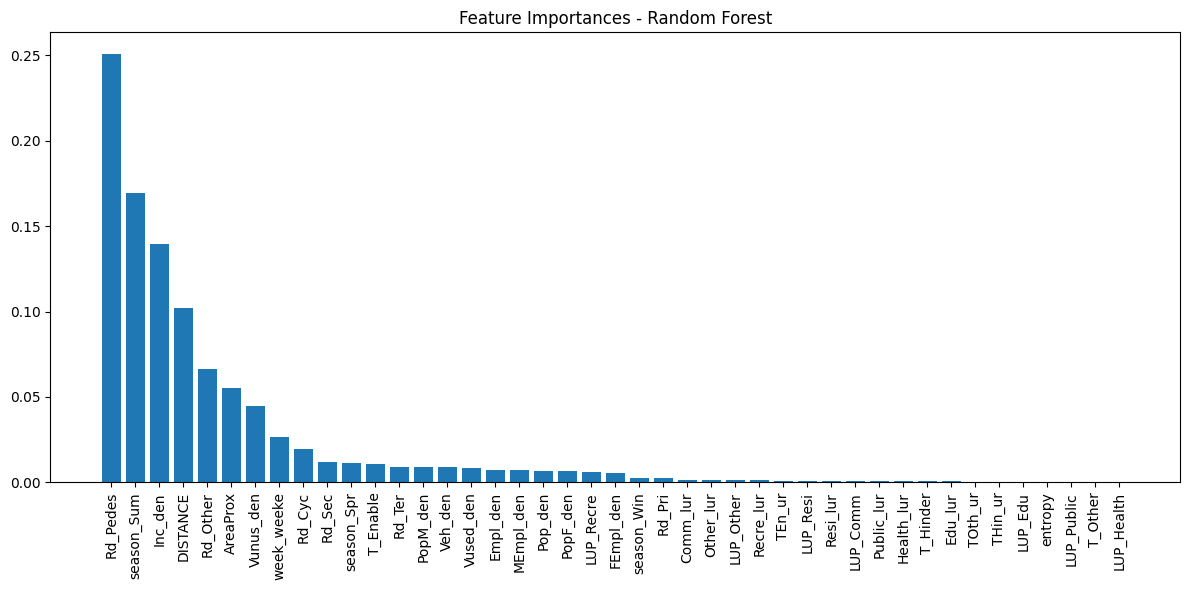

In [8]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [9]:
importance_scores = {feature_names[i]: importances[i] for i in range(len(importances))}
sorted_importances = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
top_50_columns = [item[0] for item in sorted_importances[:60]]
print(top_50_columns)

['Rd_Pedes', 'season_Sum', 'Inc_den', 'DISTANCE', 'Rd_Other', 'AreaProx', 'Vunus_den', 'week_weeke', 'Rd_Cyc', 'Rd_Sec', 'season_Spr', 'T_Enable', 'Rd_Ter', 'PopM_den', 'Veh_den', 'Vused_den', 'Empl_den', 'MEmpl_den', 'Pop_den', 'PopF_den', 'LUP_Recre', 'FEmpl_den', 'season_Win', 'Rd_Pri', 'Comm_lur', 'Other_lur', 'LUP_Other', 'Recre_lur', 'TEn_ur', 'LUP_Resi', 'Resi_lur', 'LUP_Comm', 'Public_lur', 'Health_lur', 'T_Hinder', 'Edu_lur', 'TOth_ur', 'THin_ur', 'LUP_Edu', 'entropy', 'LUP_Public', 'T_Other', 'LUP_Health']


## VIF (variance_inflation_factor)

In [10]:
sorted_feature_names = top_50_columns
sorted_feature_names.remove('Other_lur')
sorted_feature_names.remove('TOth_ur')

In [11]:
features_test = sorted_feature_names
col_test = data[features_test]

vif_data = pd.DataFrame()
vif_data["feature"] = col_test.columns
vif_data["VIF"] = [variance_inflation_factor(col_test.values.astype(float), i)
                          for i in range(len(col_test.columns))]

vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data.to_string(index=False, float_format='%.2f'))

   feature        VIF
   Pop_den 6380359.17
  Empl_den 5132379.02
  PopF_den 1607144.15
  PopM_den 1591439.90
 FEmpl_den 1298508.76
 MEmpl_den 1278675.67
   Veh_den  634180.29
 Vused_den  442501.77
 Vunus_den   18711.14
   entropy      21.88
   Inc_den      15.98
    Rd_Ter      10.42
  DISTANCE       8.99
  AreaProx       6.88
  Rd_Pedes       6.83
    TEn_ur       6.62
    Rd_Cyc       4.27
 Recre_lur       3.51
   THin_ur       3.48
  Resi_lur       3.38
Health_lur       3.16
  T_Enable       3.11
   Edu_lur       2.99
  Comm_lur       2.99
LUP_Health       2.99
 LUP_Recre       2.68
Public_lur       2.68
    Rd_Sec       2.54
   LUP_Edu       2.32
  T_Hinder       2.25
  LUP_Resi       2.19
season_Sum       2.18
LUP_Public       2.12
  Rd_Other       2.06
season_Win       2.05
week_weeke       1.96
season_Spr       1.91
    Rd_Pri       1.84
  LUP_Comm       1.80
   T_Other       1.65
 LUP_Other       1.58


In [12]:
sorted_feature_names = vif_data[vif_data['VIF'] < 25]['feature']
print(len(sorted_feature_names))
sorted_feature_names=sorted_feature_names.tolist()
sorted_feature_names

32


['entropy',
 'Inc_den',
 'Rd_Ter',
 'DISTANCE',
 'AreaProx',
 'Rd_Pedes',
 'TEn_ur',
 'Rd_Cyc',
 'Recre_lur',
 'THin_ur',
 'Resi_lur',
 'Health_lur',
 'T_Enable',
 'Edu_lur',
 'Comm_lur',
 'LUP_Health',
 'LUP_Recre',
 'Public_lur',
 'Rd_Sec',
 'LUP_Edu',
 'T_Hinder',
 'LUP_Resi',
 'season_Sum',
 'LUP_Public',
 'Rd_Other',
 'season_Win',
 'week_weeke',
 'season_Spr',
 'Rd_Pri',
 'LUP_Comm',
 'T_Other',
 'LUP_Other']

C:\Users\omkarp\AppData\Local\Temp\ipykernel_13584\2001719514.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


[Text(0, 0.5, 'Inc_den'),
 Text(0, 1.5, 'Rd_Ter'),
 Text(0, 2.5, 'DISTANCE'),
 Text(0, 3.5, 'AreaProx'),
 Text(0, 4.5, 'Rd_Pedes'),
 Text(0, 5.5, 'TEn_ur'),
 Text(0, 6.5, 'Rd_Cyc'),
 Text(0, 7.5, 'THin_ur'),
 Text(0, 8.5, 'Resi_lur'),
 Text(0, 9.5, 'Edu_lur'),
 Text(0, 10.5, 'Comm_lur'),
 Text(0, 11.5, 'LUP_Health'),
 Text(0, 12.5, 'LUP_Recre'),
 Text(0, 13.5, 'Rd_Sec'),
 Text(0, 14.5, 'LUP_Edu'),
 Text(0, 15.5, 'LUP_Resi'),
 Text(0, 16.5, 'season_Sum'),
 Text(0, 17.5, 'LUP_Public'),
 Text(0, 18.5, 'Rd_Other'),
 Text(0, 19.5, 'season_Win'),
 Text(0, 20.5, 'week_weeke'),
 Text(0, 21.5, 'season_Spr'),
 Text(0, 22.5, 'Rd_Pri'),
 Text(0, 23.5, 'LUP_Comm'),
 Text(0, 24.5, 'T_Other'),
 Text(0, 25.5, 'LUP_Other')]

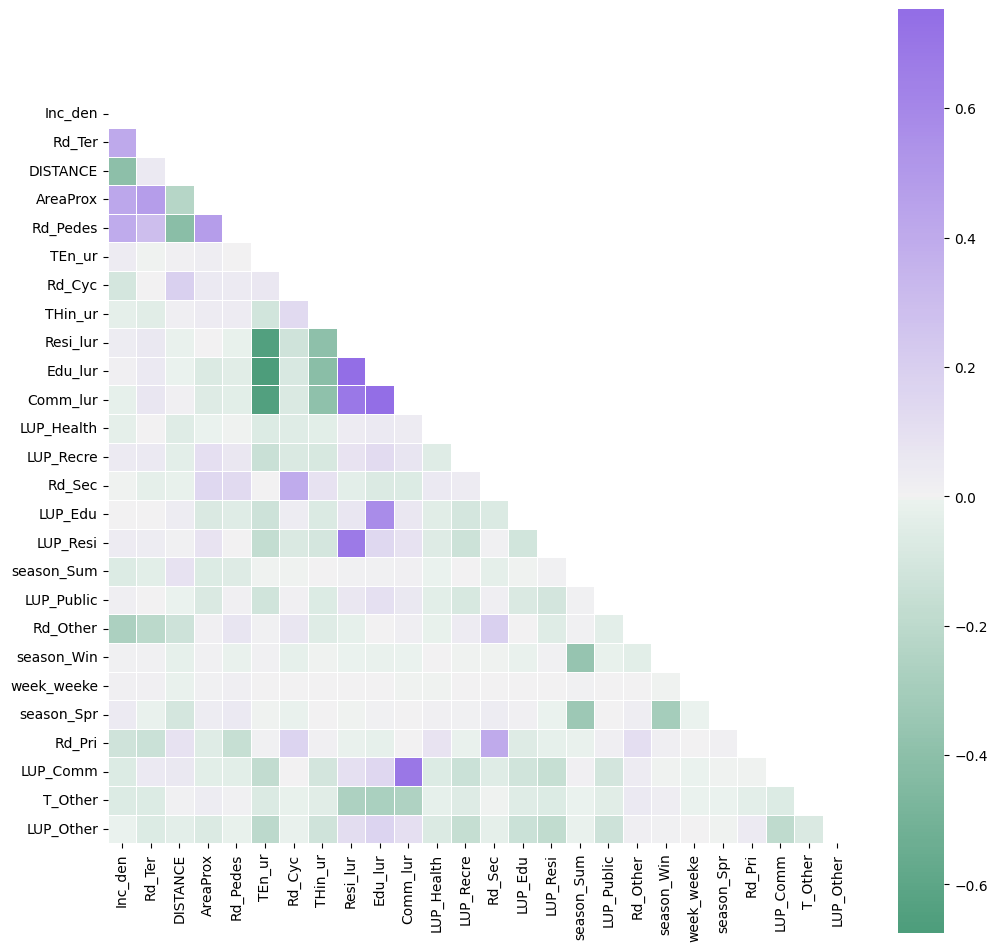

In [13]:
sorted_feature_names.remove('entropy')
sorted_feature_names.remove('T_Enable')
sorted_feature_names.remove('T_Hinder')
sorted_feature_names.remove('Health_lur')
sorted_feature_names.remove('Public_lur')
sorted_feature_names.remove('Recre_lur')

# Features to remove for lower correlation
# sorted_feature_names.remove('Edu_lur')
# sorted_feature_names.remove('Comm_lur')
# sorted_feature_names.remove('LUP_Resi')
# sorted_feature_names.remove('TEn_ur')
# sorted_feature_names.remove('Inc_den')
# sorted_feature_names.remove('Rd_Pedes')
# sorted_feature_names.remove('Rd_Comml')

features_1 = sorted_feature_names
corr = data[features_1].corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True,linewidths=.5, cbar_kws={"shrink": 1})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 10)
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 10)

In [14]:
print(len(features_1))
X = data[features_1].values
y = data['count_trip'].values
features_1

26


['Inc_den',
 'Rd_Ter',
 'DISTANCE',
 'AreaProx',
 'Rd_Pedes',
 'TEn_ur',
 'Rd_Cyc',
 'THin_ur',
 'Resi_lur',
 'Edu_lur',
 'Comm_lur',
 'LUP_Health',
 'LUP_Recre',
 'Rd_Sec',
 'LUP_Edu',
 'LUP_Resi',
 'season_Sum',
 'LUP_Public',
 'Rd_Other',
 'season_Win',
 'week_weeke',
 'season_Spr',
 'Rd_Pri',
 'LUP_Comm',
 'T_Other',
 'LUP_Other']

# Random Forest Model

In [15]:
x_train, x_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [16]:
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean squared error: {:.2f}".format(mse))
print("RMSE: %f" % (rmse))
print("R-squared score: {:.2f}".format(r2))

Mean squared error: 1295.22
RMSE: 35.989217
R-squared score: 0.90


In [17]:
param_dist = {'n_estimators': [100, 150, 200, 250],
              'max_depth': list(np.arange(1, len(features_1), 2)),
              'max_features': list(np.arange(3, len(features_1), 2))}

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=20, n_jobs=-1)

with tqdm(total=1) as pbar:
        random_search.fit(x_train, y_train)
        pbar.update(1)

print("Best Hyperparameters: ", random_search.best_params_)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [04:53<00:00, 293.57s/it]

Best Hyperparameters:  {'n_estimators': 100, 'max_features': 15, 'max_depth': 21}


In [18]:
best_params = random_search.best_params_
rf = RandomForestRegressor(**best_params, random_state=42)

scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(rf, X, y, cv=20, scoring=scoring, return_estimator=True)
estimators = cv_results['estimator']

test_r2_scores = []
test_mse_scores = -cv_results['test_neg_mean_squared_error']
test_rmse_scores = -cv_results['test_neg_root_mean_squared_error']
test_mae_scores = -cv_results['test_neg_mean_absolute_error']

for i, estimator in enumerate(estimators):
    y_pred = estimator.predict(x_test)
    r2 = r2_score(y_test, y_pred)
    test_r2_scores.append(r2)
    
print("Mean CV R2 score:", np.mean(test_r2_scores))
print("Mean CV MSE score:", np.mean(test_mse_scores))
print("Mean CV RMSE score:", np.mean(test_rmse_scores))
print("Mean CV MAE score:", np.mean(test_mae_scores))

Mean CV R2 score: 0.970091112553493
Mean CV MSE score: 6366.925679372777
Mean CV RMSE score: 61.73964609803214
Mean CV MAE score: 35.232929650739244


In [19]:
rf.fit(x_train, y_train)
importances = rf.feature_importances_
print(features_1, importances)

['Inc_den', 'Rd_Ter', 'DISTANCE', 'AreaProx', 'Rd_Pedes', 'TEn_ur', 'Rd_Cyc', 'THin_ur', 'Resi_lur', 'Edu_lur', 'Comm_lur', 'LUP_Health', 'LUP_Recre', 'Rd_Sec', 'LUP_Edu', 'LUP_Resi', 'season_Sum', 'LUP_Public', 'Rd_Other', 'season_Win', 'week_weeke', 'season_Spr', 'Rd_Pri', 'LUP_Comm', 'T_Other', 'LUP_Other'] [0.14488844 0.0224799  0.14064151 0.10831428 0.2195896  0.00264556
 0.02411233 0.0006266  0.00253073 0.0016591  0.00549519 0.00024355
 0.01188704 0.01943162 0.00062892 0.00207473 0.16943469 0.00083136
 0.06764483 0.0076928  0.02537026 0.00937276 0.00558855 0.00222962
 0.00039976 0.00418626]


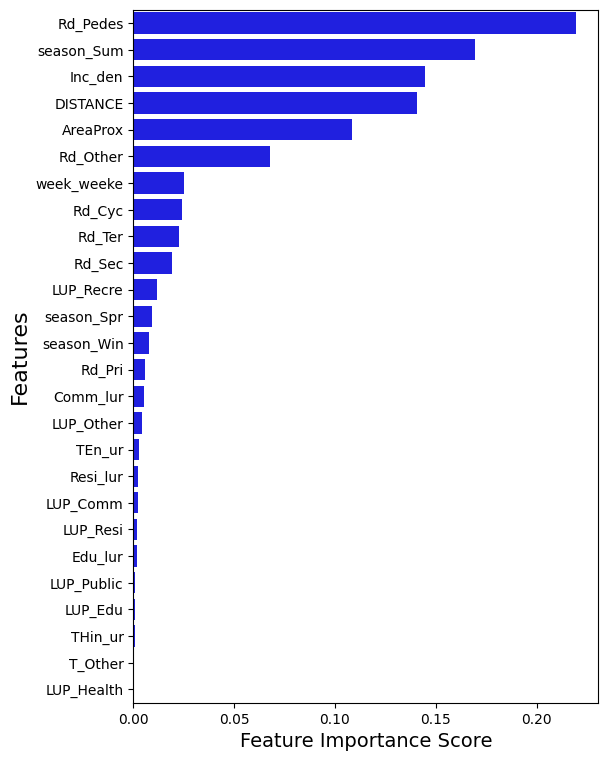

In [20]:
result1 = pd.DataFrame({"features":features_1, "importances":rf.feature_importances_})
result = result1.sort_values(by='importances',ascending=False)
plt.figure(figsize=(6,9))
sns.barplot(x=result['importances'], y=result['features'], color='blue')
plt.xlabel('Feature Importance Score', fontsize='14')
plt.ylabel('Features', fontsize='16')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# XGBoost Model

In [21]:
import xgboost as xgb
model = None
model = XGBRegressor(n_estimators=10, max_depth=20, verbosity=0)
model.fit(x_train, y_train)
model.predict(x_train)

xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(x_train, y_train)
score = xgbr.score(x_train, y_train)  
print("Training score: ", score)

scores = cross_val_score(xgbr, x_train, y_train,cv=20)
print("Mean cross-validation R2: %.2f" % scores.mean())

kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, x_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

ypred = xgbr.predict(x_test)
mse = mean_squared_error(y_test, ypred)
print(f'mse: ', mse , '\nrmse: ',mse**(1/2) )

Training score:  0.998415291190479
Mean cross-validation R2: 0.93
K-fold CV average score: 0.92
mse:  815.6715867298411 
rmse:  28.55996475365194


## Hyperparameter optimisation

In [22]:
regressor=xgb.XGBRegressor(objective="reg:squarederror")
n_estimators = [50,100,500,900,1100,1500]
max_depth = [2,3,5,10,15, 20, 25]
booster = ['gbtree', 'gblinear']
learning_rate = [0.05, 0.1, 0.15, 0.2]
min_child_weight = [1,2,3,4,5]
base_score = [0.25,0.5,0.75,1]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster,
    'base_score':base_score
}

random_cv= RandomizedSearchCV(estimator=regressor,param_distributions=hyperparameter_grid,
                             cv=20, n_iter=5, scoring='neg_mean_absolute_error',
                             n_jobs=4, verbose=2, return_train_score=True,
                             random_state=123)

In [23]:
with tqdm(file=sys.stdout, desc="RandomizedSearchCV") as pbar:
        random_result = random_cv.fit(x_train, y_train)
        pbar.update()
    
print(f'The best hyperparameters are {random_result.best_params_}')

RandomizedSearchCV: 0it [00:00, ?it/s]Fitting 20 folds for each of 5 candidates, totalling 100 fits
RandomizedSearchCV: 1it [02:16, 136.40s/it]
The best hyperparameters are {'n_estimators': 1100, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.2, 'booster': 'gbtree', 'base_score': 0.75}


In [24]:
# Training with best hyperparameters
base_score = 0.75
n_estimators = 1100
learning_rate = 0.2
min_child_weight = 2
max_depth = 5
booster = 'gbtree'

regressor = xgb.XGBRegressor(base_score=base_score, booster=booster, colsample_bylevel=1,colsample_bynode=1,colsample_bytree=1,
                             enable_categorical=False,gamma=0, importance_type=None,interaction_constraints='',
                             learning_rate=learning_rate, max_delta_step=0,max_depth=max_depth, min_child_weight=min_child_weight,
                             n_estimators=n_estimators, n_jobs=8,num_parallel_tree=1, predictor='gpu_predictor',random_state=0,
                             reg_alpha=0,reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
                             validate_parameters=1, verbosity=0)
regressor.fit(x_train,y_train)

XGBRegressor(base_score=0.75, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=5,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, n_estimators=1100, n_jobs=8,
             num_parallel_tree=1, predictor='gpu_predictor', random_state=0, ...)

In [25]:
scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
cv_results = cross_validate(regressor, x_train, y_train, cv=20, scoring=scoring)

mse_scores = -cv_results['test_neg_mean_squared_error']
rmse_scores = mse_scores ** 0.5
mae_scores = -cv_results['test_neg_mean_absolute_error']
r2_scores = cv_results['test_r2']

print("Mean MSE:", mse_scores.mean())
print("Mean RMSE:", rmse_scores.mean())
print("Mean MAE:", mae_scores.mean())
print("Mean R2:", r2_scores.mean())

Mean MSE: 752.6948107658816
Mean RMSE: 25.43232569751721
Mean MAE: 12.642182829225455
Mean R2: 0.9534560763860694


In [26]:
importances = regressor.feature_importances_
print(features_1, importances)

['Inc_den', 'Rd_Ter', 'DISTANCE', 'AreaProx', 'Rd_Pedes', 'TEn_ur', 'Rd_Cyc', 'THin_ur', 'Resi_lur', 'Edu_lur', 'Comm_lur', 'LUP_Health', 'LUP_Recre', 'Rd_Sec', 'LUP_Edu', 'LUP_Resi', 'season_Sum', 'LUP_Public', 'Rd_Other', 'season_Win', 'week_weeke', 'season_Spr', 'Rd_Pri', 'LUP_Comm', 'T_Other', 'LUP_Other'] [0.09816338 0.00967928 0.19430533 0.06476679 0.27097473 0.0204648
 0.01623225 0.00172301 0.03127347 0.00176101 0.0044177  0.00087428
 0.02866353 0.0370786  0.00147833 0.00185306 0.1152828  0.00240824
 0.03862903 0.00168164 0.01060698 0.00668122 0.02763252 0.00205307
 0.00166339 0.00965152]


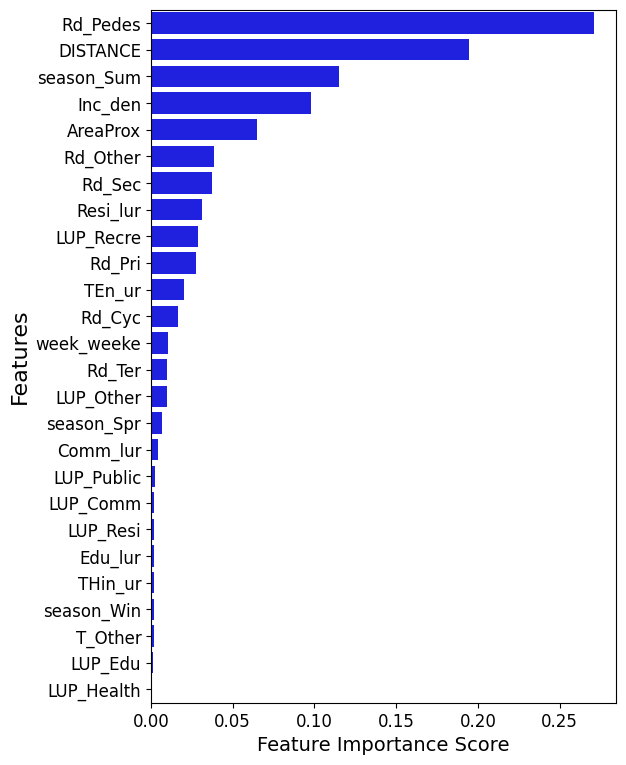

In [27]:
result1 = pd.DataFrame({"features":features_1, "importances":regressor.feature_importances_})
result = result1.sort_values(by='importances',ascending=False)
plt.figure(figsize=(6,9))
sns.barplot(x=result['importances'], y=result['features'], color='blue')
plt.xlabel('Feature Importance Score', fontsize='14')
plt.ylabel('Features', fontsize='16')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [28]:
print(result)

      features  importances
4     Rd_Pedes     0.270975
2     DISTANCE     0.194305
16  season_Sum     0.115283
0      Inc_den     0.098163
3     AreaProx     0.064767
18    Rd_Other     0.038629
13      Rd_Sec     0.037079
8     Resi_lur     0.031273
12   LUP_Recre     0.028664
22      Rd_Pri     0.027633
5       TEn_ur     0.020465
6       Rd_Cyc     0.016232
20  week_weeke     0.010607
1       Rd_Ter     0.009679
25   LUP_Other     0.009652
21  season_Spr     0.006681
10    Comm_lur     0.004418
17  LUP_Public     0.002408
23    LUP_Comm     0.002053
15    LUP_Resi     0.001853
9      Edu_lur     0.001761
7      THin_ur     0.001723
19  season_Win     0.001682
24     T_Other     0.001663
14     LUP_Edu     0.001478
11  LUP_Health     0.000874
